In [1]:
# %%
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Masking
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras.backend as K
import time

# %%
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# %%
#### Change inputs
modelID = '93js'
## noaa stations following same order of the outputs
NOAAstations = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

#### Define paths and load data
# pathData = Path(r'../../../data/random_split')
pathData = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/inputs/random_split')
# pathColSample = pathData.parent
pathColSample = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
X_train_file = 'X_train_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_train_file = 'y_train_augmentedAllX50_def.npy'
X_test_file = 'X_test_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_test_file = 'y_test_augmentedAllX50_def.npy'

#### some hyperparameters
batch_size = 100
epochs = 1000
fold = 1 ## no cross validation


/home/tacuevas/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-26 17:32:23.924438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 17:32:24.933204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tacuevas/miniconda3/envs/tf2/lib/
2023-12-26 17:32:24.933331: W tensorflow/compiler/xla/stream_executor/platform

In [2]:
#### path to store outputs
#pathOut0 = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/81')
pathOut = Path(f'../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/{modelID}')
#pathOut0 = pathOut0/st

#### class to save best model
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, pathout, fold, modelID):
        super(CustomCallback, self).__init__()
        self.pathout = pathout
        self.fold = fold
        self.modelID = modelID
        self.previous_val_loss = float('inf')  # Initialize with a high value
        self.best_epoch = None
        self.best_model = None
    
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.previous_val_loss:
            self.model.save(self.pathout / f'bestModel_{self.modelID}_fold{self.fold}.tf')
            self.previous_val_loss = current_val_loss
            self.best_epoch = epoch
            self.best_model = self.model
            with open(self.pathout / f'best_model.txt', 'a') as fout:
                fout.write(f'Best model saved for fold {self.fold}: epoch {self.best_epoch}, val_loss: {current_val_loss:0.3f}\n')

#### load data
X_train = np.load(pathData/X_train_file)
y_train = np.load(pathData/Y_train_file)
X_test = np.load(pathData/X_test_file)
y_test = np.load(pathData/Y_test_file)

#### train/validation split
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### pathout
#pathOut = pathOut0/st

columns_sample = pd.read_csv(pathColSample/'dct_tracksAll_batch02_lengthCorr_tides_resampled_SAMPLE.csv', index_col = 0)

## inputs
cols = ['wind_speed', 'pressure', 'rad_to_max_ws', 'forward_speed_u', 'forward_speed_v',
            'dist_to_duck', 'Duck', 'dist_to_oregon', 'Oregon', 'dist_to_hatteras', 'Hatteras', 'dist_to_beaufort', 'Beaufort', 'dist_to_wilmington', 'Wilmington', 'dist_to_wrightsville', 'Wrightsville', 
            'wind_speed_fft', 'pressure_fft', 'rad_to_max_ws_fft',
            'forward_speed_u_fft', 'forward_speed_v_fft']

In [3]:
## extract inputs idx from the full input array
idx_cols = [list(columns_sample).index(x) for x in cols]
X_train_sub2 = X_train_sub[:, :, idx_cols]
X_val2 = X_val[:, :, idx_cols]
X_test2 = X_test[:, :, idx_cols]

In [4]:
try:
    os.mkdir(pathOut)
except:
    pass

#### Define model
model = Sequential([
                Masking(-9999, input_shape=(X_train_sub2.shape[1:])),
                Conv1D(16, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(32, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(64, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(6, activation='relu'),
            ])

optimizer = RMSprop(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), 
                metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

#### callback to save model with lower val_loss
callback = CustomCallback(pathOut, fold=fold, modelID=modelID)
#### train the model
t0 = time.time()
history = model.fit(X_train_sub2, y_train_sub, batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data = (X_val2, y_val), callbacks=[callback])
print(f'Training time: {(time.time() - t0)/3600:0.3f} hrs')

#### save outputs
dfhist = pd.DataFrame.from_dict(history.history)
dfhist.to_csv(pathOut/f'history_{modelID}_fold{fold}.csv')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 235, 22)           0         
                                                                 
 conv1d (Conv1D)             (None, 233, 16)           1072      


2023-12-26 17:32:37.399158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 17:32:38.782828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4356 MB memory:  -> device: 0, name: Quadro P2000, pci bus id: 0000:5b:00.0, compute capability: 6.1
2023-12-26 17:32:38.783799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3620 MB memory:  -> device: 1, name: Quadro P2000, pci bus id: 0000:9e:00.0, compute capability: 6.1


                                                                 
 batch_normalization (BatchN  (None, 233, 16)          64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 116, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 114, 32)           1568      
                                                                 
 batch_normalization_1 (Batc  (None, 114, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 57, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 

2023-12-26 17:32:45.539789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-12-26 17:32:45.889604: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-26 17:32:46.396724: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7d7400c7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-26 17:32:46.396810: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2023-12-26 17:32:46.396836: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro P2000, Compute Capability 6.1
2023-12-26 17:32:46.411511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-26 17:32:46.492681: I tensorflow/tsl/platform/default/subprocess.cc

629/629 [==============================] - ETA: 0s - loss: 0.2097 - mse: 0.4813 - mae: 0.5017 - rmse: 0.6938

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 22s 27ms/step - loss: 0.2097 - mse: 0.4813 - mae: 0.5017 - rmse: 0.6938 - val_loss: 0.1056 - val_mse: 0.2356 - val_mae: 0.3135 - val_rmse: 0.4854
Epoch 2/1000
629/629 [==============================] - ETA: 0s - loss: 0.1312 - mse: 0.2887 - mae: 0.3786 - rmse: 0.5373

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 17s 26ms/step - loss: 0.1312 - mse: 0.2887 - mae: 0.3786 - rmse: 0.5373 - val_loss: 0.0810 - val_mse: 0.1735 - val_mae: 0.2799 - val_rmse: 0.4165
Epoch 3/1000
627/629 [============================>.] - ETA: 0s - loss: 0.1031 - mse: 0.2218 - mae: 0.3290 - rmse: 0.4710

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.1031 - mse: 0.2218 - mae: 0.3290 - rmse: 0.4710 - val_loss: 0.0687 - val_mse: 0.1458 - val_mae: 0.2521 - val_rmse: 0.3818
Epoch 4/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0873 - mse: 0.1856 - mae: 0.2991 - rmse: 0.4308

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0873 - mse: 0.1856 - mae: 0.2991 - rmse: 0.4308 - val_loss: 0.0593 - val_mse: 0.1235 - val_mae: 0.2384 - val_rmse: 0.3515
Epoch 5/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0783 - mse: 0.1654 - mae: 0.2804 - rmse: 0.4067

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0783 - mse: 0.1653 - mae: 0.2804 - rmse: 0.4066 - val_loss: 0.0564 - val_mse: 0.1170 - val_mae: 0.2291 - val_rmse: 0.3420
Epoch 6/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0718 - mse: 0.1504 - mae: 0.2669 - rmse: 0.3878

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0718 - mse: 0.1504 - mae: 0.2669 - rmse: 0.3878 - val_loss: 0.0554 - val_mse: 0.1149 - val_mae: 0.2255 - val_rmse: 0.3390
Epoch 7/1000
629/629 [==============================] - ETA: 0s - loss: 0.0676 - mse: 0.1412 - mae: 0.2579 - rmse: 0.3758

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0676 - mse: 0.1412 - mae: 0.2579 - rmse: 0.3758 - val_loss: 0.0506 - val_mse: 0.1044 - val_mae: 0.2161 - val_rmse: 0.3230
Epoch 8/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0638 - mse: 0.1330 - mae: 0.2502 - rmse: 0.3646

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0638 - mse: 0.1330 - mae: 0.2502 - rmse: 0.3646 - val_loss: 0.0473 - val_mse: 0.0970 - val_mae: 0.2110 - val_rmse: 0.3115
Epoch 9/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0609 - mse: 0.1264 - mae: 0.2445 - rmse: 0.3555

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0609 - mse: 0.1263 - mae: 0.2445 - rmse: 0.3554 - val_loss: 0.0453 - val_mse: 0.0925 - val_mae: 0.2082 - val_rmse: 0.3042
Epoch 10/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0586 - mse: 0.1215 - mae: 0.2403 - rmse: 0.3486

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0586 - mse: 0.1215 - mae: 0.2403 - rmse: 0.3486 - val_loss: 0.0447 - val_mse: 0.0914 - val_mae: 0.2059 - val_rmse: 0.3024
Epoch 11/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0565 - mse: 0.1168 - mae: 0.2360 - rmse: 0.3417

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0565 - mse: 0.1168 - mae: 0.2360 - rmse: 0.3417 - val_loss: 0.0431 - val_mse: 0.0879 - val_mae: 0.2039 - val_rmse: 0.2965
Epoch 12/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0544 - mse: 0.1124 - mae: 0.2316 - rmse: 0.3353

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0544 - mse: 0.1124 - mae: 0.2315 - rmse: 0.3352 - val_loss: 0.0385 - val_mse: 0.0782 - val_mae: 0.1957 - val_rmse: 0.2796
Epoch 13/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0527 - mse: 0.1088 - mae: 0.2280 - rmse: 0.3298 - val_loss: 0.0386 - val_mse: 0.0785 - val_mae: 0.1927 - val_rmse: 0.2801
Epoch 14/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0511 - mse: 0.1053 - mae: 0.2242 - rmse: 0.3245 - val_loss: 0.0405 - val_mse: 0.0828 - val_mae: 0.1954 - val_rmse: 0.2877
Epoch 15/1000
629/629 [==============================] - ETA: 0s - loss: 0.0495 - mse: 0.1018 - mae: 0.2207 - rmse: 0.3190

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0495 - mse: 0.1018 - mae: 0.2207 - rmse: 0.3190 - val_loss: 0.0367 - val_mse: 0.0746 - val_mae: 0.1872 - val_rmse: 0.2731
Epoch 16/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0480 - mse: 0.0987 - mae: 0.2171 - rmse: 0.3142

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0480 - mse: 0.0988 - mae: 0.2171 - rmse: 0.3143 - val_loss: 0.0363 - val_mse: 0.0737 - val_mae: 0.1860 - val_rmse: 0.2715
Epoch 17/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0466 - mse: 0.0956 - mae: 0.2136 - rmse: 0.3092

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0466 - mse: 0.0957 - mae: 0.2137 - rmse: 0.3093 - val_loss: 0.0317 - val_mse: 0.0641 - val_mae: 0.1776 - val_rmse: 0.2532
Epoch 18/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0456 - mse: 0.0935 - mae: 0.2111 - rmse: 0.3058

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0456 - mse: 0.0935 - mae: 0.2111 - rmse: 0.3058 - val_loss: 0.0310 - val_mse: 0.0625 - val_mae: 0.1758 - val_rmse: 0.2500
Epoch 19/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0446 - mse: 0.0914 - mae: 0.2085 - rmse: 0.3023

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0446 - mse: 0.0914 - mae: 0.2085 - rmse: 0.3023 - val_loss: 0.0308 - val_mse: 0.0622 - val_mae: 0.1747 - val_rmse: 0.2493
Epoch 20/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0436 - mse: 0.0894 - mae: 0.2061 - rmse: 0.2990

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0436 - mse: 0.0894 - mae: 0.2061 - rmse: 0.2990 - val_loss: 0.0293 - val_mse: 0.0590 - val_mae: 0.1710 - val_rmse: 0.2429
Epoch 21/1000
629/629 [==============================] - ETA: 0s - loss: 0.0426 - mse: 0.0871 - mae: 0.2036 - rmse: 0.2951

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0426 - mse: 0.0871 - mae: 0.2036 - rmse: 0.2951 - val_loss: 0.0282 - val_mse: 0.0568 - val_mae: 0.1691 - val_rmse: 0.2382
Epoch 22/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0417 - mse: 0.0853 - mae: 0.2015 - rmse: 0.2920

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0417 - mse: 0.0853 - mae: 0.2015 - rmse: 0.2920 - val_loss: 0.0282 - val_mse: 0.0567 - val_mae: 0.1679 - val_rmse: 0.2381
Epoch 23/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0406 - mse: 0.0830 - mae: 0.1991 - rmse: 0.2880

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0406 - mse: 0.0830 - mae: 0.1991 - rmse: 0.2880 - val_loss: 0.0273 - val_mse: 0.0550 - val_mae: 0.1656 - val_rmse: 0.2346
Epoch 24/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0401 - mse: 0.0817 - mae: 0.1976 - rmse: 0.2859

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0401 - mse: 0.0817 - mae: 0.1976 - rmse: 0.2859 - val_loss: 0.0259 - val_mse: 0.0520 - val_mae: 0.1623 - val_rmse: 0.2280
Epoch 25/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0393 - mse: 0.0802 - mae: 0.1958 - rmse: 0.2831

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0393 - mse: 0.0802 - mae: 0.1958 - rmse: 0.2831 - val_loss: 0.0247 - val_mse: 0.0496 - val_mae: 0.1593 - val_rmse: 0.2227
Epoch 26/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0390 - mse: 0.0795 - mae: 0.1946 - rmse: 0.2820 - val_loss: 0.0260 - val_mse: 0.0523 - val_mae: 0.1619 - val_rmse: 0.2286
Epoch 27/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0385 - mse: 0.0785 - mae: 0.1934 - rmse: 0.2802 - val_loss: 0.0270 - val_mse: 0.0543 - val_mae: 0.1635 - val_rmse: 0.2329
Epoch 28/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0377 - mse: 0.0768 - mae: 0.1916 - rmse: 0.2771

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0377 - mse: 0.0768 - mae: 0.1916 - rmse: 0.2771 - val_loss: 0.0237 - val_mse: 0.0476 - val_mae: 0.1559 - val_rmse: 0.2182
Epoch 29/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0372 - mse: 0.0757 - mae: 0.1903 - rmse: 0.2751 - val_loss: 0.0253 - val_mse: 0.0508 - val_mae: 0.1597 - val_rmse: 0.2254
Epoch 30/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0367 - mse: 0.0748 - mae: 0.1890 - rmse: 0.2735 - val_loss: 0.0239 - val_mse: 0.0480 - val_mae: 0.1561 - val_rmse: 0.2190
Epoch 31/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0361 - mse: 0.0734 - mae: 0.1877 - rmse: 0.2709

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0361 - mse: 0.0734 - mae: 0.1877 - rmse: 0.2709 - val_loss: 0.0232 - val_mse: 0.0465 - val_mae: 0.1546 - val_rmse: 0.2155
Epoch 32/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0355 - mse: 0.0722 - mae: 0.1862 - rmse: 0.2687 - val_loss: 0.0250 - val_mse: 0.0501 - val_mae: 0.1585 - val_rmse: 0.2239
Epoch 33/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0353 - mse: 0.0717 - mae: 0.1852 - rmse: 0.2678 - val_loss: 0.0232 - val_mse: 0.0465 - val_mae: 0.1537 - val_rmse: 0.2157
Epoch 34/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0351 - mse: 0.0714 - mae: 0.1847 - rmse: 0.2672 - val_loss: 0.0247 - val_mse: 0.0496 - val_mae: 0.1568 - val_rmse: 0.2228
Epoch 35/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0346 - mse: 0.0701 - mae: 0.1835 - rmse: 0.2648

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0346 - mse: 0.0702 - mae: 0.1835 - rmse: 0.2649 - val_loss: 0.0216 - val_mse: 0.0432 - val_mae: 0.1494 - val_rmse: 0.2079
Epoch 36/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0345 - mse: 0.0700 - mae: 0.1831 - rmse: 0.2645

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0345 - mse: 0.0699 - mae: 0.1831 - rmse: 0.2645 - val_loss: 0.0212 - val_mse: 0.0425 - val_mae: 0.1483 - val_rmse: 0.2061
Epoch 37/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0341 - mse: 0.0694 - mae: 0.1820 - rmse: 0.2634 - val_loss: 0.0215 - val_mse: 0.0430 - val_mae: 0.1499 - val_rmse: 0.2073
Epoch 38/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0336 - mse: 0.0681 - mae: 0.1808 - rmse: 0.2610 - val_loss: 0.0243 - val_mse: 0.0487 - val_mae: 0.1559 - val_rmse: 0.2207
Epoch 39/1000
629/629 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0673 - mae: 0.1799 - rmse: 0.2595

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0332 - mse: 0.0673 - mae: 0.1799 - rmse: 0.2595 - val_loss: 0.0196 - val_mse: 0.0393 - val_mae: 0.1449 - val_rmse: 0.1983
Epoch 40/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0331 - mse: 0.0670 - mae: 0.1794 - rmse: 0.2588 - val_loss: 0.0217 - val_mse: 0.0435 - val_mae: 0.1483 - val_rmse: 0.2085
Epoch 41/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0328 - mse: 0.0664 - mae: 0.1784 - rmse: 0.2578 - val_loss: 0.0212 - val_mse: 0.0425 - val_mae: 0.1472 - val_rmse: 0.2063
Epoch 42/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0324 - mse: 0.0656 - mae: 0.1775 - rmse: 0.2561 - val_loss: 0.0218 - val_mse: 0.0438 - val_mae: 0.1483 - val_rmse: 0.2092
Epoch 43/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0322 - mse: 0.0653 - mae: 0.1770 - rmse: 0.2555 - val_loss: 0.0200 - val_mse: 0.0401 - val_mae: 0.1449 - val_rmse: 0.2004

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0315 - mse: 0.0638 - mae: 0.1750 - rmse: 0.2526 - val_loss: 0.0192 - val_mse: 0.0384 - val_mae: 0.1418 - val_rmse: 0.1959
Epoch 47/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0312 - mse: 0.0632 - mae: 0.1743 - rmse: 0.2515 - val_loss: 0.0217 - val_mse: 0.0434 - val_mae: 0.1482 - val_rmse: 0.2083
Epoch 48/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0311 - mse: 0.0630 - mae: 0.1737 - rmse: 0.2509 - val_loss: 0.0205 - val_mse: 0.0411 - val_mae: 0.1447 - val_rmse: 0.2028
Epoch 49/1000
629/629 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0619 - mae: 0.1725 - rmse: 0.2488

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0306 - mse: 0.0619 - mae: 0.1725 - rmse: 0.2488 - val_loss: 0.0189 - val_mse: 0.0378 - val_mae: 0.1408 - val_rmse: 0.1945
Epoch 50/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0308 - mse: 0.0623 - mae: 0.1726 - rmse: 0.2497 - val_loss: 0.0206 - val_mse: 0.0412 - val_mae: 0.1445 - val_rmse: 0.2030
Epoch 51/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0302 - mse: 0.0612 - mae: 0.1714 - rmse: 0.2474 - val_loss: 0.0195 - val_mse: 0.0390 - val_mae: 0.1415 - val_rmse: 0.1975
Epoch 52/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0302 - mse: 0.0610 - mae: 0.1712 - rmse: 0.2470

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0302 - mse: 0.0610 - mae: 0.1712 - rmse: 0.2470 - val_loss: 0.0179 - val_mse: 0.0358 - val_mae: 0.1373 - val_rmse: 0.1892
Epoch 53/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0299 - mse: 0.0604 - mae: 0.1703 - rmse: 0.2458 - val_loss: 0.0182 - val_mse: 0.0365 - val_mae: 0.1378 - val_rmse: 0.1910
Epoch 54/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0295 - mse: 0.0597 - mae: 0.1697 - rmse: 0.2444 - val_loss: 0.0195 - val_mse: 0.0390 - val_mae: 0.1414 - val_rmse: 0.1974
Epoch 55/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0295 - mse: 0.0598 - mae: 0.1691 - rmse: 0.2445 - val_loss: 0.0181 - val_mse: 0.0362 - val_mae: 0.1379 - val_rmse: 0.1902
Epoch 56/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0291 - mse: 0.0588 - mae: 0.1682 - rmse: 0.2426 - val_loss: 0.0184 - val_mse: 0.0369 - val_mae: 0.1388 - val_rmse: 0.1921

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0291 - mse: 0.0590 - mae: 0.1683 - rmse: 0.2428 - val_loss: 0.0174 - val_mse: 0.0349 - val_mae: 0.1352 - val_rmse: 0.1867
Epoch 58/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0289 - mse: 0.0586 - mae: 0.1674 - rmse: 0.2420 - val_loss: 0.0176 - val_mse: 0.0353 - val_mae: 0.1356 - val_rmse: 0.1879
Epoch 59/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0287 - mse: 0.0581 - mae: 0.1670 - rmse: 0.2410

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0287 - mse: 0.0581 - mae: 0.1670 - rmse: 0.2410 - val_loss: 0.0172 - val_mse: 0.0345 - val_mae: 0.1355 - val_rmse: 0.1856
Epoch 60/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0284 - mse: 0.0574 - mae: 0.1662 - rmse: 0.2395 - val_loss: 0.0174 - val_mse: 0.0348 - val_mae: 0.1357 - val_rmse: 0.1866
Epoch 61/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0283 - mse: 0.0571 - mae: 0.1659 - rmse: 0.2390 - val_loss: 0.0180 - val_mse: 0.0361 - val_mae: 0.1364 - val_rmse: 0.1899
Epoch 62/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0282 - mse: 0.0569 - mae: 0.1655 - rmse: 0.2385 - val_loss: 0.0172 - val_mse: 0.0345 - val_mae: 0.1340 - val_rmse: 0.1857
Epoch 63/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0280 - mse: 0.0565 - mae: 0.1649 - rmse: 0.2378

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0280 - mse: 0.0565 - mae: 0.1649 - rmse: 0.2378 - val_loss: 0.0164 - val_mse: 0.0328 - val_mae: 0.1324 - val_rmse: 0.1811
Epoch 64/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0280 - mse: 0.0565 - mae: 0.1648 - rmse: 0.2377 - val_loss: 0.0180 - val_mse: 0.0360 - val_mae: 0.1363 - val_rmse: 0.1897
Epoch 65/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0277 - mse: 0.0559 - mae: 0.1641 - rmse: 0.2364 - val_loss: 0.0179 - val_mse: 0.0358 - val_mae: 0.1355 - val_rmse: 0.1892
Epoch 66/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0275 - mse: 0.0556 - mae: 0.1635 - rmse: 0.2358 - val_loss: 0.0180 - val_mse: 0.0360 - val_mae: 0.1353 - val_rmse: 0.1897
Epoch 67/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0274 - mse: 0.0553 - mae: 0.1631 - rmse: 0.2353 - val_loss: 0.0179 - val_mse: 0.0357 - val_mae: 0.1352 - val_rmse: 0.1891

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0272 - mse: 0.0549 - mae: 0.1624 - rmse: 0.2342 - val_loss: 0.0164 - val_mse: 0.0328 - val_mae: 0.1314 - val_rmse: 0.1811
Epoch 69/1000
629/629 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0548 - mae: 0.1623 - rmse: 0.2342

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0271 - mse: 0.0548 - mae: 0.1623 - rmse: 0.2342 - val_loss: 0.0161 - val_mse: 0.0323 - val_mae: 0.1304 - val_rmse: 0.1797
Epoch 70/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0268 - mse: 0.0540 - mae: 0.1612 - rmse: 0.2325 - val_loss: 0.0182 - val_mse: 0.0364 - val_mae: 0.1360 - val_rmse: 0.1909
Epoch 71/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0267 - mse: 0.0538 - mae: 0.1610 - rmse: 0.2320 - val_loss: 0.0173 - val_mse: 0.0346 - val_mae: 0.1332 - val_rmse: 0.1859
Epoch 72/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0268 - mse: 0.0542 - mae: 0.1614 - rmse: 0.2327 - val_loss: 0.0169 - val_mse: 0.0338 - val_mae: 0.1324 - val_rmse: 0.1839
Epoch 73/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0266 - mse: 0.0538 - mae: 0.1608 - rmse: 0.2319 - val_loss: 0.0165 - val_mse: 0.0331 - val_mae: 0.1317 - val_rmse: 0.1819

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0257 - mse: 0.0520 - mae: 0.1579 - rmse: 0.2279 - val_loss: 0.0160 - val_mse: 0.0320 - val_mae: 0.1288 - val_rmse: 0.1789
Epoch 81/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0256 - mse: 0.0517 - mae: 0.1575 - rmse: 0.2273 - val_loss: 0.0170 - val_mse: 0.0341 - val_mae: 0.1321 - val_rmse: 0.1846
Epoch 82/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0256 - mse: 0.0516 - mae: 0.1574 - rmse: 0.2271

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0256 - mse: 0.0516 - mae: 0.1574 - rmse: 0.2271 - val_loss: 0.0158 - val_mse: 0.0316 - val_mae: 0.1278 - val_rmse: 0.1777
Epoch 83/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0255 - mse: 0.0515 - mae: 0.1571 - rmse: 0.2269 - val_loss: 0.0161 - val_mse: 0.0322 - val_mae: 0.1291 - val_rmse: 0.1795
Epoch 84/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0256 - mse: 0.0516 - mae: 0.1572 - rmse: 0.2272

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0256 - mse: 0.0516 - mae: 0.1572 - rmse: 0.2272 - val_loss: 0.0156 - val_mse: 0.0311 - val_mae: 0.1278 - val_rmse: 0.1765
Epoch 85/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0253 - mse: 0.0510 - mae: 0.1564 - rmse: 0.2259 - val_loss: 0.0164 - val_mse: 0.0327 - val_mae: 0.1298 - val_rmse: 0.1809
Epoch 86/1000
629/629 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0502 - mae: 0.1555 - rmse: 0.2241

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0249 - mse: 0.0502 - mae: 0.1555 - rmse: 0.2241 - val_loss: 0.0154 - val_mse: 0.0309 - val_mae: 0.1270 - val_rmse: 0.1758
Epoch 87/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0251 - mse: 0.0507 - mae: 0.1560 - rmse: 0.2252 - val_loss: 0.0165 - val_mse: 0.0329 - val_mae: 0.1303 - val_rmse: 0.1815
Epoch 88/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0248 - mse: 0.0500 - mae: 0.1550 - rmse: 0.2237

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0248 - mse: 0.0500 - mae: 0.1550 - rmse: 0.2237 - val_loss: 0.0154 - val_mse: 0.0308 - val_mae: 0.1265 - val_rmse: 0.1755
Epoch 89/1000
629/629 [==============================] - ETA: 0s - loss: 0.0247 - mse: 0.0498 - mae: 0.1549 - rmse: 0.2232

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0247 - mse: 0.0498 - mae: 0.1549 - rmse: 0.2232 - val_loss: 0.0151 - val_mse: 0.0302 - val_mae: 0.1262 - val_rmse: 0.1738
Epoch 90/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0249 - mse: 0.0503 - mae: 0.1554 - rmse: 0.2243 - val_loss: 0.0173 - val_mse: 0.0347 - val_mae: 0.1324 - val_rmse: 0.1862
Epoch 91/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0246 - mse: 0.0497 - mae: 0.1542 - rmse: 0.2230 - val_loss: 0.0156 - val_mse: 0.0312 - val_mae: 0.1270 - val_rmse: 0.1767
Epoch 92/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0245 - mse: 0.0494 - mae: 0.1539 - rmse: 0.2222 - val_loss: 0.0168 - val_mse: 0.0336 - val_mae: 0.1313 - val_rmse: 0.1834
Epoch 93/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0246 - mse: 0.0496 - mae: 0.1541 - rmse: 0.2228 - val_loss: 0.0170 - val_mse: 0.0341 - val_mae: 0.1307 - val_rmse: 0.1847

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0240 - mse: 0.0483 - mae: 0.1521 - rmse: 0.2199 - val_loss: 0.0150 - val_mse: 0.0301 - val_mae: 0.1244 - val_rmse: 0.1734
Epoch 99/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0485 - mae: 0.1522 - rmse: 0.2201 - val_loss: 0.0169 - val_mse: 0.0339 - val_mae: 0.1297 - val_rmse: 0.1841
Epoch 100/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0238 - mse: 0.0480 - mae: 0.1517 - rmse: 0.2191 - val_loss: 0.0155 - val_mse: 0.0310 - val_mae: 0.1266 - val_rmse: 0.1760
Epoch 101/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0238 - mse: 0.0479 - mae: 0.1516 - rmse: 0.2188

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0238 - mse: 0.0479 - mae: 0.1516 - rmse: 0.2189 - val_loss: 0.0148 - val_mse: 0.0296 - val_mae: 0.1244 - val_rmse: 0.1721
Epoch 102/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0479 - mae: 0.1512 - rmse: 0.2189 - val_loss: 0.0150 - val_mse: 0.0301 - val_mae: 0.1254 - val_rmse: 0.1734
Epoch 103/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0236 - mse: 0.0476 - mae: 0.1511 - rmse: 0.2181 - val_loss: 0.0151 - val_mse: 0.0302 - val_mae: 0.1258 - val_rmse: 0.1739
Epoch 104/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0236 - mse: 0.0476 - mae: 0.1508 - rmse: 0.2181 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1276 - val_rmse: 0.1799
Epoch 105/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0235 - mse: 0.0474 - mae: 0.1507 - rmse: 0.2178

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0235 - mse: 0.0474 - mae: 0.1507 - rmse: 0.2178 - val_loss: 0.0136 - val_mse: 0.0273 - val_mae: 0.1205 - val_rmse: 0.1651
Epoch 106/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0470 - mae: 0.1502 - rmse: 0.2169 - val_loss: 0.0145 - val_mse: 0.0291 - val_mae: 0.1227 - val_rmse: 0.1705
Epoch 107/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0468 - mae: 0.1495 - rmse: 0.2162 - val_loss: 0.0157 - val_mse: 0.0314 - val_mae: 0.1262 - val_rmse: 0.1771
Epoch 108/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0468 - mae: 0.1498 - rmse: 0.2163 - val_loss: 0.0145 - val_mse: 0.0291 - val_mae: 0.1226 - val_rmse: 0.1705
Epoch 109/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0471 - mae: 0.1499 - rmse: 0.2169 - val_loss: 0.0150 - val_mse: 0.0300 - val_mae: 0.1236 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0222 - mse: 0.0446 - mae: 0.1463 - rmse: 0.2112 - val_loss: 0.0132 - val_mse: 0.0265 - val_mae: 0.1182 - val_rmse: 0.1627
Epoch 126/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0221 - mse: 0.0444 - mae: 0.1457 - rmse: 0.2108 - val_loss: 0.0139 - val_mse: 0.0278 - val_mae: 0.1207 - val_rmse: 0.1667
Epoch 127/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0220 - mse: 0.0442 - mae: 0.1454 - rmse: 0.2102 - val_loss: 0.0142 - val_mse: 0.0285 - val_mae: 0.1213 - val_rmse: 0.1688
Epoch 128/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0221 - mse: 0.0446 - mae: 0.1459 - rmse: 0.2112 - val_loss: 0.0138 - val_mse: 0.0277 - val_mae: 0.1200 - val_rmse: 0.1663
Epoch 129/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0219 - mse: 0.0441 - mae: 0.1455 - rmse: 0.2100 - val_loss: 0.0139 - val_mse: 0.0279 - val_mae: 0.1200 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0216 - mse: 0.0435 - mae: 0.1441 - rmse: 0.2086 - val_loss: 0.0132 - val_mse: 0.0264 - val_mae: 0.1172 - val_rmse: 0.1625
Epoch 140/1000
629/629 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0430 - mae: 0.1433 - rmse: 0.2073

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0213 - mse: 0.0430 - mae: 0.1433 - rmse: 0.2073 - val_loss: 0.0128 - val_mse: 0.0255 - val_mae: 0.1163 - val_rmse: 0.1598
Epoch 141/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0214 - mse: 0.0431 - mae: 0.1434 - rmse: 0.2075 - val_loss: 0.0151 - val_mse: 0.0302 - val_mae: 0.1231 - val_rmse: 0.1738
Epoch 142/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0215 - mse: 0.0434 - mae: 0.1438 - rmse: 0.2082 - val_loss: 0.0149 - val_mse: 0.0299 - val_mae: 0.1223 - val_rmse: 0.1729
Epoch 143/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0215 - mse: 0.0433 - mae: 0.1435 - rmse: 0.2080 - val_loss: 0.0154 - val_mse: 0.0309 - val_mae: 0.1238 - val_rmse: 0.1757
Epoch 144/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0213 - mse: 0.0428 - mae: 0.1431 - rmse: 0.2069 - val_loss: 0.0159 - val_mse: 0.0318 - val_mae: 0.1254 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0208 - mse: 0.0419 - mae: 0.1410 - rmse: 0.2046 - val_loss: 0.0127 - val_mse: 0.0254 - val_mae: 0.1149 - val_rmse: 0.1593
Epoch 158/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0209 - mse: 0.0420 - mae: 0.1410 - rmse: 0.2049 - val_loss: 0.0133 - val_mse: 0.0267 - val_mae: 0.1171 - val_rmse: 0.1633
Epoch 159/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0206 - mse: 0.0416 - mae: 0.1405 - rmse: 0.2040 - val_loss: 0.0144 - val_mse: 0.0289 - val_mae: 0.1204 - val_rmse: 0.1700
Epoch 160/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0208 - mse: 0.0418 - mae: 0.1407 - rmse: 0.2045 - val_loss: 0.0141 - val_mse: 0.0281 - val_mae: 0.1196 - val_rmse: 0.1677
Epoch 161/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0206 - mse: 0.0414 - mae: 0.1403 - rmse: 0.2035 - val_loss: 0.0134 - val_mse: 0.0269 - val_mae: 0.1179 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0205 - mse: 0.0413 - mae: 0.1399 - rmse: 0.2032 - val_loss: 0.0122 - val_mse: 0.0244 - val_mae: 0.1133 - val_rmse: 0.1562
Epoch 164/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0204 - mse: 0.0412 - mae: 0.1396 - rmse: 0.2029 - val_loss: 0.0151 - val_mse: 0.0301 - val_mae: 0.1220 - val_rmse: 0.1736
Epoch 165/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0204 - mse: 0.0411 - mae: 0.1396 - rmse: 0.2026 - val_loss: 0.0128 - val_mse: 0.0257 - val_mae: 0.1147 - val_rmse: 0.1602
Epoch 166/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0205 - mse: 0.0412 - mae: 0.1397 - rmse: 0.2030 - val_loss: 0.0144 - val_mse: 0.0288 - val_mae: 0.1205 - val_rmse: 0.1698
Epoch 167/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0205 - mse: 0.0414 - mae: 0.1396 - rmse: 0.2034 - val_loss: 0.0128 - val_mse: 0.0256 - val_mae: 0.1152 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0204 - mse: 0.0410 - mae: 0.1394 - rmse: 0.2025 - val_loss: 0.0117 - val_mse: 0.0235 - val_mae: 0.1115 - val_rmse: 0.1533
Epoch 169/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0204 - mse: 0.0412 - mae: 0.1394 - rmse: 0.2029 - val_loss: 0.0138 - val_mse: 0.0275 - val_mae: 0.1183 - val_rmse: 0.1659
Epoch 170/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0202 - mse: 0.0407 - mae: 0.1389 - rmse: 0.2018 - val_loss: 0.0130 - val_mse: 0.0260 - val_mae: 0.1158 - val_rmse: 0.1611
Epoch 171/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0204 - mse: 0.0411 - mae: 0.1392 - rmse: 0.2026 - val_loss: 0.0140 - val_mse: 0.0279 - val_mae: 0.1195 - val_rmse: 0.1671
Epoch 172/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0202 - mse: 0.0407 - mae: 0.1391 - rmse: 0.2018 - val_loss: 0.0127 - val_mse: 0.0253 - val_mae: 0.1146 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0194 - mse: 0.0390 - mae: 0.1354 - rmse: 0.1975 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1096 - val_rmse: 0.1523
Epoch 203/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0192 - mse: 0.0387 - mae: 0.1350 - rmse: 0.1967 - val_loss: 0.0116 - val_mse: 0.0233 - val_mae: 0.1099 - val_rmse: 0.1526
Epoch 204/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0193 - mse: 0.0387 - mae: 0.1351 - rmse: 0.1968 - val_loss: 0.0140 - val_mse: 0.0280 - val_mae: 0.1183 - val_rmse: 0.1674
Epoch 205/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0192 - mse: 0.0386 - mae: 0.1349 - rmse: 0.1966 - val_loss: 0.0151 - val_mse: 0.0302 - val_mae: 0.1208 - val_rmse: 0.1738
Epoch 206/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0191 - mse: 0.0385 - mae: 0.1348 - rmse: 0.1962 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1107 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0190 - mse: 0.0382 - mae: 0.1342 - rmse: 0.1956 - val_loss: 0.0116 - val_mse: 0.0231 - val_mae: 0.1093 - val_rmse: 0.1520
Epoch 209/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0192 - mse: 0.0387 - mae: 0.1348 - rmse: 0.1966 - val_loss: 0.0137 - val_mse: 0.0275 - val_mae: 0.1165 - val_rmse: 0.1657
Epoch 210/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0191 - mse: 0.0384 - mae: 0.1344 - rmse: 0.1959 - val_loss: 0.0121 - val_mse: 0.0241 - val_mae: 0.1114 - val_rmse: 0.1553
Epoch 211/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0190 - mse: 0.0383 - mae: 0.1344 - rmse: 0.1958 - val_loss: 0.0116 - val_mse: 0.0231 - val_mae: 0.1094 - val_rmse: 0.1521
Epoch 212/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0191 - mse: 0.0385 - mae: 0.1344 - rmse: 0.1961 - val_loss: 0.0128 - val_mse: 0.0257 - val_mae: 0.1137 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0187 - mse: 0.0376 - mae: 0.1326 - rmse: 0.1938 - val_loss: 0.0106 - val_mse: 0.0212 - val_mae: 0.1051 - val_rmse: 0.1454
Epoch 231/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0187 - mse: 0.0376 - mae: 0.1326 - rmse: 0.1939 - val_loss: 0.0112 - val_mse: 0.0224 - val_mae: 0.1078 - val_rmse: 0.1496
Epoch 232/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0187 - mse: 0.0376 - mae: 0.1324 - rmse: 0.1938 - val_loss: 0.0128 - val_mse: 0.0255 - val_mae: 0.1130 - val_rmse: 0.1598
Epoch 233/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0185 - mse: 0.0373 - mae: 0.1322 - rmse: 0.1931 - val_loss: 0.0132 - val_mse: 0.0265 - val_mae: 0.1143 - val_rmse: 0.1628
Epoch 234/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0185 - mse: 0.0373 - mae: 0.1323 - rmse: 0.1930 - val_loss: 0.0121 - val_mse: 0.0243 - val_mae: 0.1114 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0176 - mse: 0.0355 - mae: 0.1285 - rmse: 0.1884 - val_loss: 0.0106 - val_mse: 0.0211 - val_mae: 0.1048 - val_rmse: 0.1453
Epoch 294/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0176 - mse: 0.0354 - mae: 0.1284 - rmse: 0.1881 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1094 - val_rmse: 0.1543
Epoch 295/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0175 - mse: 0.0352 - mae: 0.1280 - rmse: 0.1877 - val_loss: 0.0117 - val_mse: 0.0234 - val_mae: 0.1087 - val_rmse: 0.1529
Epoch 296/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0174 - mse: 0.0351 - mae: 0.1280 - rmse: 0.1872 - val_loss: 0.0115 - val_mse: 0.0230 - val_mae: 0.1074 - val_rmse: 0.1518
Epoch 297/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0175 - mse: 0.0351 - mae: 0.1281 - rmse: 0.1873 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1085 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0174 - mse: 0.0350 - mae: 0.1276 - rmse: 0.1870 - val_loss: 0.0097 - val_mse: 0.0194 - val_mae: 0.1006 - val_rmse: 0.1393
Epoch 311/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0174 - mse: 0.0349 - mae: 0.1274 - rmse: 0.1869 - val_loss: 0.0109 - val_mse: 0.0217 - val_mae: 0.1052 - val_rmse: 0.1474
Epoch 312/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0173 - mse: 0.0348 - mae: 0.1273 - rmse: 0.1865 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1074 - val_rmse: 0.1522
Epoch 313/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0173 - mse: 0.0348 - mae: 0.1273 - rmse: 0.1866 - val_loss: 0.0109 - val_mse: 0.0218 - val_mae: 0.1046 - val_rmse: 0.1477
Epoch 314/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0172 - mse: 0.0345 - mae: 0.1269 - rmse: 0.1859 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1077 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0171 - mse: 0.0343 - mae: 0.1263 - rmse: 0.1853 - val_loss: 0.0097 - val_mse: 0.0194 - val_mae: 0.1006 - val_rmse: 0.1391
Epoch 338/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0170 - mse: 0.0342 - mae: 0.1259 - rmse: 0.1849 - val_loss: 0.0120 - val_mse: 0.0240 - val_mae: 0.1088 - val_rmse: 0.1549
Epoch 339/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0170 - mse: 0.0342 - mae: 0.1262 - rmse: 0.1850 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1064 - val_rmse: 0.1522
Epoch 340/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0169 - mse: 0.0341 - mae: 0.1259 - rmse: 0.1846 - val_loss: 0.0113 - val_mse: 0.0227 - val_mae: 0.1064 - val_rmse: 0.1506
Epoch 341/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0170 - mse: 0.0341 - mae: 0.1259 - rmse: 0.1847 - val_loss: 0.0121 - val_mse: 0.0241 - val_mae: 0.1086 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0165 - mse: 0.0332 - mae: 0.1242 - rmse: 0.1823 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.0985 - val_rmse: 0.1372
Epoch 386/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0164 - mse: 0.0331 - mae: 0.1239 - rmse: 0.1819 - val_loss: 0.0119 - val_mse: 0.0239 - val_mae: 0.1073 - val_rmse: 0.1545
Epoch 387/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0165 - mse: 0.0331 - mae: 0.1242 - rmse: 0.1818 - val_loss: 0.0119 - val_mse: 0.0239 - val_mae: 0.1079 - val_rmse: 0.1545
Epoch 388/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0165 - mse: 0.0332 - mae: 0.1242 - rmse: 0.1822 - val_loss: 0.0118 - val_mse: 0.0236 - val_mae: 0.1066 - val_rmse: 0.1536
Epoch 389/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0165 - mse: 0.0332 - mae: 0.1242 - rmse: 0.1823 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1022 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0157 - mse: 0.0316 - mae: 0.1210 - rmse: 0.1778 - val_loss: 0.0089 - val_mse: 0.0179 - val_mae: 0.0960 - val_rmse: 0.1338
Epoch 465/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0159 - mse: 0.0319 - mae: 0.1213 - rmse: 0.1785 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1006 - val_rmse: 0.1422
Epoch 466/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0157 - mse: 0.0316 - mae: 0.1211 - rmse: 0.1776 - val_loss: 0.0110 - val_mse: 0.0220 - val_mae: 0.1037 - val_rmse: 0.1484
Epoch 467/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0159 - mse: 0.0319 - mae: 0.1213 - rmse: 0.1787 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.0999 - val_rmse: 0.1422
Epoch 468/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0157 - mse: 0.0316 - mae: 0.1210 - rmse: 0.1778 - val_loss: 0.0095 - val_mse: 0.0191 - val_mae: 0.0990 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1188 - rmse: 0.1745 - val_loss: 0.0085 - val_mse: 0.0171 - val_mae: 0.0937 - val_rmse: 0.1306
Epoch 542/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0153 - mse: 0.0308 - mae: 0.1190 - rmse: 0.1755 - val_loss: 0.0092 - val_mse: 0.0183 - val_mae: 0.0961 - val_rmse: 0.1354
Epoch 543/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0306 - mae: 0.1187 - rmse: 0.1749 - val_loss: 0.0101 - val_mse: 0.0201 - val_mae: 0.0997 - val_rmse: 0.1418
Epoch 544/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0151 - mse: 0.0303 - mae: 0.1185 - rmse: 0.1742 - val_loss: 0.0093 - val_mse: 0.0187 - val_mae: 0.0976 - val_rmse: 0.1366
Epoch 545/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1189 - rmse: 0.1747 - val_loss: 0.0115 - val_mse: 0.0229 - val_mae: 0.1069 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1185 - rmse: 0.1746 - val_loss: 0.0085 - val_mse: 0.0170 - val_mae: 0.0940 - val_rmse: 0.1303
Epoch 547/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0153 - mse: 0.0307 - mae: 0.1191 - rmse: 0.1753 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.0990 - val_rmse: 0.1420
Epoch 548/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0152 - mse: 0.0306 - mae: 0.1189 - rmse: 0.1749 - val_loss: 0.0115 - val_mse: 0.0229 - val_mae: 0.1057 - val_rmse: 0.1514
Epoch 549/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0152 - mse: 0.0306 - mae: 0.1188 - rmse: 0.1749 - val_loss: 0.0109 - val_mse: 0.0217 - val_mae: 0.1021 - val_rmse: 0.1474
Epoch 550/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0151 - mse: 0.0302 - mae: 0.1184 - rmse: 0.1739 - val_loss: 0.0103 - val_mse: 0.0207 - val_mae: 0.1008 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0147 - mse: 0.0295 - mae: 0.1167 - rmse: 0.1718 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0915 - val_rmse: 0.1278
Epoch 619/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0147 - mse: 0.0296 - mae: 0.1170 - rmse: 0.1721 - val_loss: 0.0091 - val_mse: 0.0182 - val_mae: 0.0959 - val_rmse: 0.1350
Epoch 620/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0147 - mse: 0.0295 - mae: 0.1165 - rmse: 0.1717 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.0992 - val_rmse: 0.1421
Epoch 621/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0147 - mse: 0.0295 - mae: 0.1166 - rmse: 0.1717 - val_loss: 0.0102 - val_mse: 0.0203 - val_mae: 0.0994 - val_rmse: 0.1426
Epoch 622/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0149 - mse: 0.0299 - mae: 0.1172 - rmse: 0.1730 - val_loss: 0.0102 - val_mse: 0.0204 - val_mae: 0.1005 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0141 - mse: 0.0284 - mae: 0.1143 - rmse: 0.1684 - val_loss: 0.0081 - val_mse: 0.0161 - val_mae: 0.0901 - val_rmse: 0.1269
Epoch 756/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0286 - mae: 0.1148 - rmse: 0.1690 - val_loss: 0.0088 - val_mse: 0.0175 - val_mae: 0.0939 - val_rmse: 0.1325
Epoch 757/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1148 - rmse: 0.1689 - val_loss: 0.0092 - val_mse: 0.0184 - val_mae: 0.0947 - val_rmse: 0.1358
Epoch 758/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1146 - rmse: 0.1687 - val_loss: 0.0085 - val_mse: 0.0171 - val_mae: 0.0929 - val_rmse: 0.1306
Epoch 759/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1146 - rmse: 0.1687 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.0956 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0142 - mse: 0.0286 - mae: 0.1145 - rmse: 0.1691 - val_loss: 0.0079 - val_mse: 0.0159 - val_mae: 0.0900 - val_rmse: 0.1260
Epoch 784/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1144 - rmse: 0.1688 - val_loss: 0.0084 - val_mse: 0.0167 - val_mae: 0.0922 - val_rmse: 0.1293
Epoch 785/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0140 - mse: 0.0282 - mae: 0.1141 - rmse: 0.1678 - val_loss: 0.0093 - val_mse: 0.0186 - val_mae: 0.0958 - val_rmse: 0.1365
Epoch 786/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0284 - mae: 0.1143 - rmse: 0.1687 - val_loss: 0.0090 - val_mse: 0.0179 - val_mae: 0.0940 - val_rmse: 0.1339
Epoch 787/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0141 - mse: 0.0282 - mae: 0.1141 - rmse: 0.1680 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.0966 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0141 - mse: 0.0283 - mae: 0.1142 - rmse: 0.1682 - val_loss: 0.0079 - val_mse: 0.0158 - val_mae: 0.0900 - val_rmse: 0.1257
Epoch 818/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1142 - rmse: 0.1687 - val_loss: 0.0099 - val_mse: 0.0199 - val_mae: 0.0973 - val_rmse: 0.1410
Epoch 819/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1140 - rmse: 0.1677 - val_loss: 0.0099 - val_mse: 0.0198 - val_mae: 0.0987 - val_rmse: 0.1406
Epoch 820/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1139 - rmse: 0.1678 - val_loss: 0.0092 - val_mse: 0.0183 - val_mae: 0.0957 - val_rmse: 0.1354
Epoch 821/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0141 - mse: 0.0283 - mae: 0.1140 - rmse: 0.1683 - val_loss: 0.0089 - val_mse: 0.0178 - val_mae: 0.0944 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1136 - rmse: 0.1676 - val_loss: 0.0078 - val_mse: 0.0156 - val_mae: 0.0897 - val_rmse: 0.1250
Epoch 850/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0140 - mse: 0.0280 - mae: 0.1135 - rmse: 0.1675 - val_loss: 0.0091 - val_mse: 0.0182 - val_mae: 0.0943 - val_rmse: 0.1348
Epoch 851/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1138 - rmse: 0.1677 - val_loss: 0.0093 - val_mse: 0.0187 - val_mae: 0.0953 - val_rmse: 0.1367
Epoch 852/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0140 - mse: 0.0280 - mae: 0.1136 - rmse: 0.1674 - val_loss: 0.0089 - val_mse: 0.0178 - val_mae: 0.0936 - val_rmse: 0.1335
Epoch 853/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1136 - rmse: 0.1675 - val_loss: 0.0092 - val_mse: 0.0185 - val_mae: 0.0963 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93as/bestModel_93as_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0141 - mse: 0.0283 - mae: 0.1143 - rmse: 0.1683 - val_loss: 0.0077 - val_mse: 0.0153 - val_mae: 0.0886 - val_rmse: 0.1237
Epoch 856/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0139 - mse: 0.0279 - mae: 0.1133 - rmse: 0.1669 - val_loss: 0.0096 - val_mse: 0.0193 - val_mae: 0.0969 - val_rmse: 0.1388
Epoch 857/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0139 - mse: 0.0280 - mae: 0.1135 - rmse: 0.1672 - val_loss: 0.0097 - val_mse: 0.0193 - val_mae: 0.0974 - val_rmse: 0.1390
Epoch 858/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0139 - mse: 0.0278 - mae: 0.1132 - rmse: 0.1669 - val_loss: 0.0091 - val_mse: 0.0182 - val_mae: 0.0955 - val_rmse: 0.1351
Epoch 859/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0139 - mse: 0.0279 - mae: 0.1134 - rmse: 0.1670 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.0959 - val_rmse: 0.

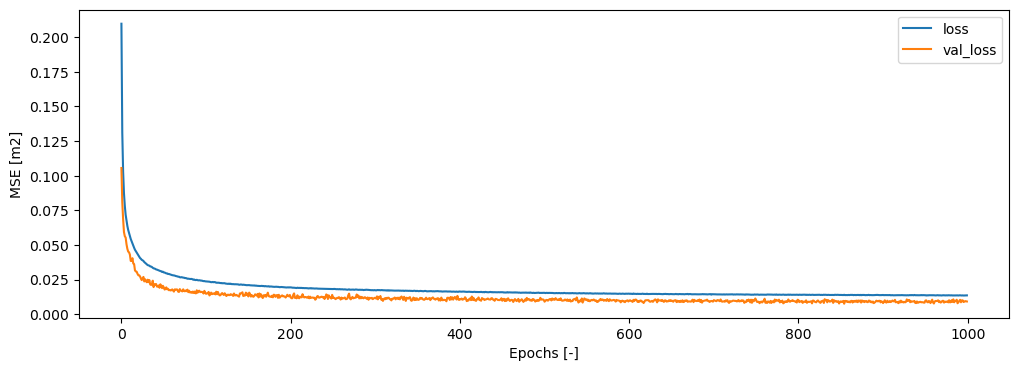

In [5]:
fig, ax = plt.subplots(figsize = (12, 4))
dfhist[['loss', 'val_loss']].plot(ax = ax)
ax.set_xlabel('Epochs [-]')
ax.set_ylabel('MSE [m2]')
fig.savefig(pathOut/f'trainValCurve_{modelID}_fold{fold}.png', dpi = 100, 
            bbox_inches = 'tight')

In [6]:
predictions = callback.best_model.predict(X_val2)

492/492 [==============================] - 3s 6ms/step


In [7]:
dfVal = pd.DataFrame(y_val.reshape(y_val.shape[:2]), columns = NOAAstations)
dfPred = pd.DataFrame(predictions, columns = [f'{x}_pred' for x in NOAAstations])
dfAll = pd.concat([dfVal, dfPred], axis = 1)
dfAll.to_csv(pathOut/f'predValSet_{modelID}.csv')

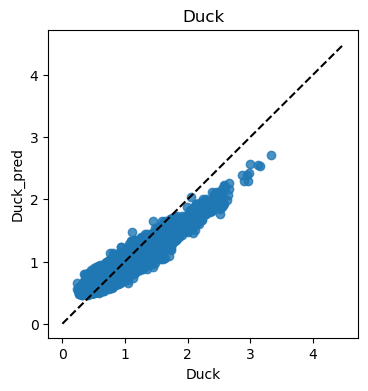

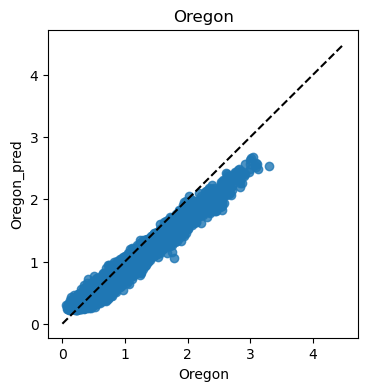

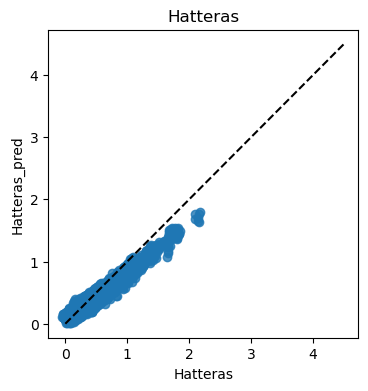

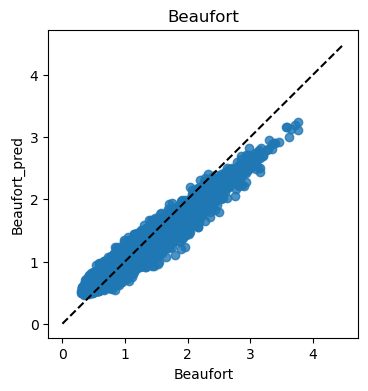

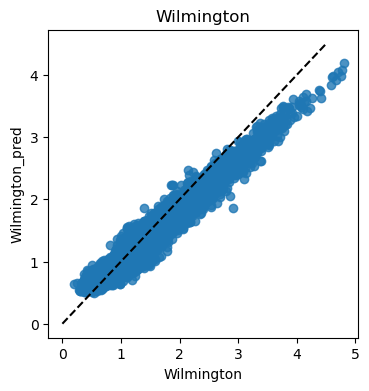

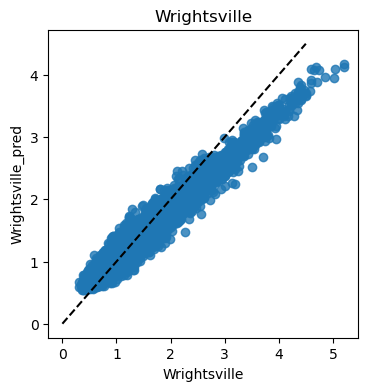

In [8]:
for i in range(6):
    fig, ax = plt.subplots(figsize = (4,4))
    sns.regplot(x = dfVal.iloc[:, i], y = dfPred.iloc[:, i], ax = ax, fit_reg = False)
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), ls = '--', c = 'k')
    ax.set_title(f'{NOAAstations[i]}')
    fig.savefig(pathOut/f'predValSet_{modelID}_{NOAAstations[i]}.png',
                dpi = 100, bbox_inches = 'tight')

In [9]:
#### delete model
tf.keras.backend.clear_session()
del model
del optimizer
del callback